## Install libraries

In [ ]:
# Library for HMM
!pip3 install --upgrade --user hmmlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 3.5 MB/s eta 0:00:00


In [ ]:
# Restart kernel after installing the package.

import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## Import libraries

In [ ]:
import sys
import os
import io
import logging
from joblib import dump

from google.cloud import bigquery
from google.cloud import storage

import dask.dataframe as dd
#from dask.distributed import Client
from google.cloud import bigquery
from dask import delayed
import pandas as pd
from sklearn.utils import check_random_state
from scipy.stats import entropy

import concurrent.futures
import ast

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Python packages for data, stats
import numpy as np
import pandas as pd
import seaborn as sns
import random

# ML
import sklearn
from sklearn.decomposition import PCA, KernelPCA, NMF, TruncatedSVD
from sklearn.manifold import TSNE, LocallyLinearEmbedding, SpectralEmbedding
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier

# To get the time
from datetime import datetime

# To write on the same line
from IPython.display import clear_output

# Set a random seed for reproducibility
random_seed = 42

# Setting the random seed for various libraries
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from scipy.stats import norm


# Hidden Markov Models
#from hmmlearn import hmm, vhmm
from hmmlearn.hmm import GaussianHMM, GMMHMM, MultinomialHMM, PoissonHMM, CategoricalHMM
from hmmlearn.vhmm import VariationalGaussianHMM
from sklearn.utils import check_random_state


# Print different versions
print(sys.version)
print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Seaborn version:", sns.__version__)
print("Sklearn version:", sklearn.__version__)

# Display the number of available GPUs
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs: {num_gpus}")

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Numpy version: 1.25.2
Pandas version: 2.0.3
Seaborn version: 0.13.1
Sklearn version: 1.2.2
Number of GPUs: 0


## Variables

In [ ]:
# Pick the width of the genomic windows
GENOMIC_LENGTH = 250 # 250 or 1000 (1000 is not fully implemented yet)

# GCP variables
storage_client = storage.Client()
bq_client = bigquery.Client()
#dask_client = Client()
project = "hmh-em-deepasm"
bucket = 'hmh_deepasm'
#LOCAL_DIR = str(GENOMIC_LENGTH) + "_bp/"
ml_dataset = "ml_250bp_66267bd"


table_id = 'features_wo_hmm'
var_seq = 'cpg_directional_fm'
label_var = 'asm_not_corrected'


## Functions used in Notebook

### HMM functions

In [ ]:
def upload_blob(storage_client, bucket_name, source_file_name, folder_path):
    """
    Uploads a file to a specified folder within a Google Cloud Storage bucket, keeping the original file name.

    Parameters:
    - bucket_name: str. The name of the bucket to upload to.
    - source_file_name: str. The path to the file to upload.
    - folder_path: str. The folder path within the bucket where the file will be uploaded.

    Returns:
    None
    """

    # Get the bucket object
    bucket = storage_client.bucket(bucket_name)
    # Extract the file name from the source file path
    file_name = os.path.basename(source_file_name)

    # logging.info(f"File name {file_name}")
    # Create the full destination path
    destination_blob_name = (
        os.path.join(folder_path, file_name) if folder_path else file_name
    )

    # logging.info(f"Destination blob name: {destination_blob_name}")
    # Create a new blob and upload the file's content
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name)

    logging.info(f"File {source_file_name} uploaded to {destination_blob_name}.")



In [ ]:
def save_HMM_model_to_bucket(directory, model, short_sha, bucket, model_path, n_states):
    file_name = (
        directory + "/hmm_model_" + short_sha + "_" + str(n_states) + "states.joblib"
    )
    dump(model, file_name)
    upload_blob(storage_client, bucket, file_name, model_path)
    return None

def prepare_data_for_hmm(sequence):
    """
    Prepares a sequence of data for processing with a Hidden Markov Model (HMM).

    This function ensures the input sequence is in a 2D NumPy array format required by HMM processing routines, handling both single-dimensional sequences (interpreting them as a sequence of scalar observations) and two-dimensional sequences (interpreting them as a sequence of vector observations). It also calculates the length of the sequence, which is necessary for some HMM algorithms.

    Parameters:
    - sequence (np.ndarray): The input sequence to be processed. This can be either a 1D array of scalar observations or a 2D array of vector observations, where each row represents a timestep.

    Returns:
    - sequence (np.ndarray): The input sequence reshaped into a 2D NumPy array format, with individual observations along rows.
    - lengths (list of int): A list containing a single integer, which is the length of the input sequence. This is used by HMM algorithms that require the lengths of sequences being processed.

    Raises:
    - ValueError: If the input `sequence` has more than two dimensions, indicating it's not in an acceptable format for HMM processing.
    """
    if sequence.ndim == 1:
        sequence = np.atleast_2d(sequence).T
    elif sequence.ndim > 2:
        raise ValueError(
            "Sequence must be 1D (for single float sequence) or 2D (for sequence of vectors)"
        )
    # Determine the length of the sequence dynamically
    sequence_length = sequence.shape[0]
    # For a single sequence, the lengths list contains just one element: the sequence length
    lengths = [sequence_length]
    return sequence, lengths


def predict_hidden_states_for_sequences(model, sequences, log_frequency=100000):
    """
    Predicts the most likely hidden states for each element in a series of sequences using a trained Hidden Markov Model (HMM).
    Each sequence of observable data points is processed individually to determine the sequence's hidden states. These states represent the underlying process assumed by the HMM.
    Parameters:
    - model: The trained HMM model used for prediction.
    - sequences: A list of sequences, where each sequence is an array of numeric observable data points. Each inner array represents a sequence to be processed.
    - log_frequency: Specifies the interval of sequences processed at which progress is logged. Logging occurs every 'log_frequency' sequences.
    Returns:
    - predicted_states: A list where each element is an array of the predicted hidden states for a corresponding input sequence.
    """
    predicted_states = []
    for i, sequence in enumerate(sequences):
        # Convert sequence to a NumPy array if it's not already one
        sequence = np.asarray(sequence)
        # Ensure seq is in the right shape (n_samples, n_features)
        if sequence.ndim == 1:
            sequence = np.atleast_2d(sequence).T
        elif sequence.ndim > 2:
            raise ValueError(
                "Sequence must be 1D (for single float sequence) or 2D (for sequence of vectors)"
            )
        # Predict the most likely hidden states for the sequence
        states = model.predict(sequence)
        predicted_states.append(states)
        # Log progress
        if (i + 1) % log_frequency == 0:
            logging.info(f"Processed sequence number: {i + 1}")
    return predicted_states


def extract_features(hidden_states_sequences):
    """
    Extracts a comprehensive set of features from sequences of hidden states in a Hidden Markov Model (HMM) and provides descriptive names for each feature.
    Parameters:
    - hidden_states_sequences (list of list of int): A list of sequences, where each sequence is a list of integers representing the hidden states visited by the HMM.
    Returns:
    - Tuple: A tuple containing a 2D NumPy array of extracted features for each sequence and a list of descriptive names for each feature.
    """
    features = []
    feature_names = []  # To store names of the features
    # Determine all unique states across sequences for consistent ordering
    unique_states = sorted({state for seq in hidden_states_sequences for state in seq})
    for state in unique_states:
        feature_names.append(f"count_state_{state}")
        feature_names.append(f"proportion_state_{state}")
    for _, state_i in enumerate(unique_states):
        for _, state_j in enumerate(unique_states):
            feature_names.append(f"transition_from_{state_i}_to_{state_j}")
    feature_names.extend(["start_state", "end_state", "nb_state_changes"])
    for state in unique_states:
        feature_names.append(f"mean_duration_state_{state}")
        feature_names.append(f"variance_duration_state_{state}")
    for _, state_i in enumerate(unique_states):
        for _, state_j in enumerate(unique_states):
            feature_names.append(f"transition_probability_from_{state_i}_to_{state_j}")
    feature_names.append("entropy_state_distribution")
    for seq in hidden_states_sequences:
        seq = np.array(seq)
        sequence_features = []
        # Original features: Counts, Proportions, and Transitions
        for state in unique_states:
            count = np.sum(seq == state)
            proportion = count / len(seq)
            sequence_features.extend([count, proportion])
        # Count transitions for later use in calculating probabilities
        transitions_matrix = np.zeros((len(unique_states), len(unique_states)))
        for i, state_i in enumerate(unique_states):
            for j, state_j in enumerate(unique_states):
                transition_count = np.sum((seq[:-1] == state_i) & (seq[1:] == state_j))
                transitions_matrix[i, j] = transition_count
                sequence_features.append(transition_count)
        start_state = seq[0]
        end_state = seq[-1]
        sequence_features.extend([start_state, end_state])
        # New features
        state_changes = np.sum(seq[:-1] != seq[1:])
        sequence_features.append(state_changes)
        # Duration in States, Mean & Variance of Stay Durations
        state_durations = {state: [] for state in unique_states}
        current_state = seq[0]
        current_duration = 1
        for i in range(1, len(seq)):
            if seq[i] == current_state:
                current_duration += 1
            else:
                state_durations[current_state].append(current_duration)
                current_state = seq[i]
                current_duration = 1
        state_durations[current_state].append(current_duration)  # for the last state
        for _, durations in state_durations.items():
            if durations:
                mean_duration = np.mean(durations)
                var_duration = np.var(durations)
            else:
                mean_duration = 0
                var_duration = 0
            sequence_features.extend([mean_duration, var_duration])
        # Transition Probabilities
        for i in range(len(unique_states)):
            for j in range(len(unique_states)):
                total_transitions_from_i = np.sum(transitions_matrix[i, :])
                if total_transitions_from_i > 0:
                    transition_prob = (
                        transitions_matrix[i, j] / total_transitions_from_i
                    )
                else:
                    transition_prob = 0
                sequence_features.append(transition_prob)
        # Entropy of State Distribution
        state_counts = np.array(
            [np.sum(seq == state) for state in unique_states], dtype=float
        )
        state_probs = (
            state_counts / state_counts.sum()
            if state_counts.sum() > 0
            else np.zeros_like(state_counts)
        )
        sequence_entropy = entropy(
            state_probs
        )  # scipy's entropy function calculates from probabilities
        sequence_features.append(sequence_entropy)
        features.append(sequence_features)
    return np.array(features), feature_names


### Print classification results

In [ ]:
def evaluate_model(labels, predictions):
  confusion = confusion_matrix(labels, predictions)
  report = classification_report(labels, predictions, output_dict=True)
  sum_f1 = np.round(report['0']['f1-score'] + report['1']['f1-score'],3)
  report = classification_report(labels, predictions, output_dict=False)
  report = classification_report(labels, predictions, digits = 3)
  return sum_f1, confusion, report


## Download data for ML

In [ ]:
dic_data = {'train': {'samples': ['gm12878',
                                  'CD14',
                                  'fibroblast',
                                  'A549',
                                  'spleen_female_adult',
                                  'HeLa_S3']},
            # 'validation': {'samples': ['mammary_epithelial',
            #                            'sk_n_sh',
            #                            'CD34']},
            # 'test': {'samples': ['HepG2',
            #                      'righ_lobe_liver',
            #                      't_cell_male_adult']}
            }

In [ ]:
# Sequence of CpG cov and methylation

nb_for_training = 150000  # 200000
nb_for_testing = 100000   # 100000
for dataset_name, samples in dic_data.items():
    print("Samples", samples['samples'])
    quoted_samples = ",".join([f"'{sample}'" for sample in samples['samples']])
    print(f"Quotes samples: {quoted_samples}")

    if dataset_name == 'train':
        query = f"""
            SELECT {label_var},sample,chr, {var_seq}
            FROM {project}.{ml_dataset}.{table_id}
            WHERE sample IN ({quoted_samples}) AND
                  {var_seq} IS NOT NULL AND
                  {label_var} IS NOT NULL
            ORDER BY sample, chr, region_inf
            #LIMIT {nb_for_training}
            """
        dic_data[dataset_name]['imported'] = bq_client.query(query).to_dataframe()
    else:
        query = f"""
          SELECT {label_var}, sample, chr, {var_seq}
          FROM {project}.{ml_dataset}.{table_id}
          WHERE
            sample IN ({quoted_samples}) AND
            {var_seq} IS NOT NULL AND
            {label_var} IS NOT NULL LIMIT {nb_for_testing}
            """
        dic_data[dataset_name]['imported'] = bq_client.query(query).to_dataframe()


#  ORDER BY RAND() LIMIT {nb_for_testing}

Samples ['gm12878', 'CD14', 'fibroblast', 'A549', 'spleen_female_adult', 'HeLa_S3']
Quotes samples: 'gm12878','CD14','fibroblast','A549','spleen_female_adult','HeLa_S3'


In [ ]:
for dataset in dic_data.keys():
  dic_data[dataset]['imported'][var_seq] = dic_data[dataset]['imported'][var_seq].apply(lambda x: ast.literal_eval(x.strip('"')))

dic_data['train']['imported']

,asm_not_corrected,sample,chr,cpg_directional_fm
0,0,A549,1,"[0.0, 0.0, 0.2667, 0.3158, 0.1429, 0.1429, 0.2]"
1,0,A549,1,"[0.6558, 0.1948, 0.213, 0.504]"
2,0,A549,1,"[0.3045, 0.098, 0.6631]"
3,0,A549,1,"[0.6555, 0.3023, 0.15]"
4,0,A549,1,"[0.5091, 0.5101, 0.5333]"
...,...,...,...,...
1495531,0,spleen_female_adult,22,"[0.8, 0.4545, 0.1818, 0.2727, 0.3636, 0.5556, ..."
1495532,0,spleen_female_adult,22,"[0.0, 0.3333, 0.0, 0.0952, 0.0]"
1495533,0,spleen_female_adult,22,"[0.1667, 0.1667, 0.1538, 0.2857, 0.2667, 0.0, ..."
1495534,0,spleen_female_adult,22,"[0.1818, 0.2308, 0.2143, 0.0714, 0.0833, 0.25,..."


In [ ]:
# For CpG coverage and methylation
for dataset_name in dic_data.keys():
  dic_data[dataset_name]['all_observations'] = np.concatenate(dic_data[dataset_name]["imported"][var_seq].tolist())#np.array(np.concatenate(dic_data[dataset_name]['imported'][var_seq].values))


In [ ]:
print(f"""
    Number of CpGs used for training:
    {len(dic_data['train']['all_observations']):,}
    """)


    Number of CpGs used for training:
    8,389,258
    


## Compute weights of ASM labels for training

In [ ]:
neg, pos = np.bincount(dic_data['train']['imported'][label_var])
total = neg + pos
print('Number of regions assessed for ASM: {}\nRegions with ASM found: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0
weight_for_1 = (1 / pos)*(total)/2.0

class_weight_asm = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Number of regions assessed for ASM: 1495536
Regions with ASM found: 19305 (1.29% of total)

Weight for class 0: 0.51
Weight for class 1: 38.73


## HMM models

## Train one HMM model

In [ ]:
# Prepare data for training
reshaped_data, lengths = prepare_data_for_hmm(dic_data['train']['all_observations'])


In [ ]:
n_components = 6
rs = check_random_state(546)
cov_name = 'tied' # full, tied, spherical, diag
n_iterations = 100
n_mix = 3
algorithm='viterbi' # map or viterbi
startprob_prior = np.array([0.98, 0.01, 0.01])
model_iterations = 3

# GMMHMM # GaussianHMM, VariationalGaussianHMM, GMMHMM, CategoricalHMM, PoissonHMM
# GMMHMM NEEDS n_mix PARAMETER

best_ll = None
best_model = None
for i in range(model_iterations):
    print(f"Iteration: {i}")
    h = VariationalGaussianHMM(
              n_components,
              n_iter=n_iterations,
              #n_mix = n_mix,
              #startprob = startprob_prior,
              covariance_type = cov_name,
              algorithm = algorithm,
              random_state=rs
              ) # tol=1e-4,
    h.fit(reshaped_data, lengths)
    score = h.score(reshaped_data)
    print(f"score: {score:,}")
    if not best_ll or best_ll < score:
        best_ll = score
        best_model = h



Iteration: 0
score: 240,591.16147402723
Iteration: 1
score: 244,184.96560449104
Iteration: 2
score: 225,400.34386430174


In [ ]:
print("\nStart probabilities:")
print(best_model.startprob_)

print("\nTransition matrix:")
print(best_model.transmat_)

print("\nGaussian distribution covariances:")
print(best_model.covars_)

print("\nGaussian means:")
print(best_model.means_)


# Z = model.predict(dic_data['train']['all_observations'])
# states = pd.unique(Z)
# print(f"Unique states: {states}")


Start probabilities:
[0.08333333 0.08371297 0.08333347 0.08333401 0.58295288 0.08333333]

Transition matrix:
[[2.69056097e-01 5.08708435e-02 1.45910022e-02 2.72016606e-01
  3.14814075e-01 7.86513766e-02]
 [2.50677659e-02 8.80888732e-01 6.88155764e-02 6.25872741e-03
  6.74228440e-07 1.89685237e-02]
 [5.92145171e-02 6.57643920e-01 1.77544797e-01 1.57221062e-02
  5.68316882e-02 3.30429723e-02]
 [2.23933867e-01 1.32700372e-06 1.32684801e-06 3.19049528e-01
  3.86559369e-01 7.04545824e-02]
 [1.41630964e-01 2.02372577e-02 7.40030944e-07 2.07046129e-01
  5.66201611e-01 6.48832987e-02]
 [1.84693754e-01 9.24762980e-02 2.16083532e-02 2.01098947e-01
  3.48410643e-01 1.51712005e-01]]

Gaussian distribution covariances:
[[[0.00661966]]

 [[0.00661966]]

 [[0.00661966]]

 [[0.00661966]]

 [[0.00661966]]

 [[0.00661966]]]

Gaussian means:
[[0.56332459]
 [0.06676714]
 [0.33295763]
 [0.31941195]
 [0.08749598]
 [0.80853909]]


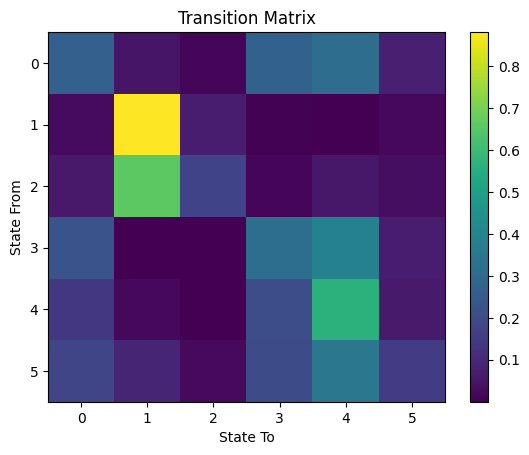

In [ ]:
# Assuming best_model.transmat_ is defined and contains the transition matrix you want to plot
# Create the figure and axis
fig, ax = plt.subplots()

# Plot the transition matrix
cax = ax.imshow(best_model.transmat_, aspect='auto')

# Create a colorbar with a reference to the imshow plot
fig.colorbar(cax)

# Set the title and labels
ax.set_title('Transition Matrix')
ax.set_xlabel('State To')
ax.set_ylabel('State From')

# Display the plot
plt.show()

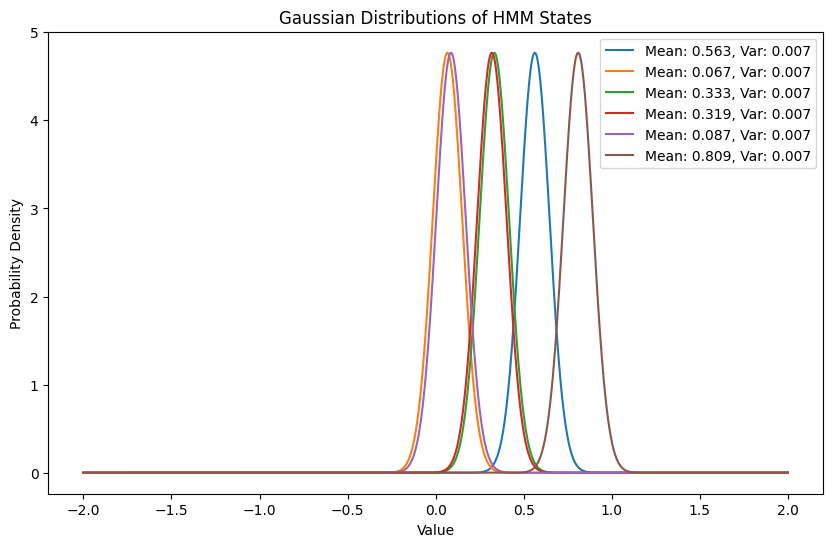

In [ ]:

# Example Gaussian parameters for 5 states
means = np.round(best_model.means_.flatten(),3)  # [1, 3, 5, 7, 9]
covariances = np.round(best_model.covars_.flatten(),3) #[0.5, 0.2, 1.0, 0.3, 0.7]  # Variance in this case

# Create a figure
plt.figure(figsize=(10, 6))

# Value range for x-axis
x = np.linspace(-2, 2, 1000)

# Plot each Gaussian
for mean, cov in zip(means, covariances):
    plt.plot(x, norm.pdf(x, mean, np.sqrt(cov)), label=f'Mean: {mean}, Var: {cov}')

plt.title('Gaussian Distributions of HMM States')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()

plt.show()


In [ ]:
for dataset_type in dic_data.keys():
  print(f"dataset: {dataset_type}")
  ###dic_data[dataset_type]['seq_scores'] = predict_asm_using_one_model(model, dic_data[dataset_type]['seq_arrays'])
  dic_data[dataset_type]['hidden_states'] = predict_hidden_states_for_sequences(best_model, dic_data[dataset_type]['imported'][var_seq])
  dic_data[dataset_type]['array_asm'] = np.array(dic_data[dataset_type]['imported'][label_var])

dataset: train
dataset: validation


In [ ]:
# Masks for selecting elements where the binary array is 0 or 1
dic_data['train']['average_hidden_states'] = np.array([np.mean(seq) for seq in dic_data['train']['hidden_states']])
for_calc = dic_data['train']['average_hidden_states']

mask_zeros = dic_data['train']['array_asm'] == 0
mask_ones = dic_data['train']['array_asm'] == 1

data_zeros = for_calc[mask_zeros]
data_ones = for_calc[mask_ones]


mean_zeros = np.mean(data_zeros)
std_dev_zeros = np.std(data_zeros)

# Statistics for elements corresponding to 1 in the binary array
mean_ones = np.mean(data_ones)
std_dev_ones = np.std(data_ones)

(mean_zeros, std_dev_zeros, mean_ones, std_dev_ones)

# Creating subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Regions without ASM", "Regions With ASM"))

# Adding histograms for each subset of data
fig.add_trace(go.Histogram(x=data_zeros, name='Zeros'), row=1, col=1)
fig.add_trace(go.Histogram(x=data_ones, name='Ones'), row=1, col=2)

# Updating layout for clarity
fig.update_layout(height=400, width=800, title_text="Distributions of average hidden states")
fig.update_traces(opacity=0.75)  # Adjusting opacity for better visualization

fig.show()


In [ ]:
for dataset_type in dic_data.keys():
  print(f"Dataset: {dataset_type}")
  dic_data[dataset_type]['hs_features'], feature_names = extract_features(dic_data[dataset_type]['hidden_states'])
  dic_data[dataset_type]['hs_features'] = pd.DataFrame(dic_data[dataset_type]['hs_features'], columns=feature_names).reset_index(
            drop=True
        )


Dataset: train
Dataset: validation


### XGBoost on the HMM features

In [ ]:
var_for_training = 'hs_features'
params = {
    'max_depth': 100,
    'eta': 0.001, # learning rate
    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': ['logloss'],
    'subsample': 0.5,
    #'scale_pos_weight': 0.02  # Adjust based on your exact dataset
}

train_labels = dic_data['train']['array_asm'].astype(int)
scale_pos_weight = len(train_labels[train_labels == 0]) / len(train_labels[train_labels == 1])
print(f"Scale pos weight: {scale_pos_weight}")

model_w_params = XGBClassifier(scale_pos_weight=scale_pos_weight, **params)
model_w_params.fit(dic_data['train'][var_for_training], train_labels)

labels = dic_data['validation']['array_asm'].astype(int)
predictions = model_w_params.predict(dic_data['validation'][var_for_training])

sum_f1, confusion, report = evaluate_model(labels, predictions)
print(f"SUm of F1s: {sum_f1}\nConfusion matrix: {confusion}\nReport:{report}")

Scale pos weight: 73.14730598121602
SUm of F1s: 1.096
Confusion matrix: [[92269  6922]
 [  258   551]]
Report:              precision    recall  f1-score   support

           0      0.997     0.930     0.963     99191
           1      0.074     0.681     0.133       809

    accuracy                          0.928    100000
   macro avg      0.535     0.806     0.548    100000
weighted avg      0.990     0.928     0.956    100000

